In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

c:\Users\kiril\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data Dictionary

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

In [2]:
df = pd.read_csv("Hotel Reservations.csv")
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


<h1>Plan:</h1>

1. Check dataset for any NaN values
2. Check dataset for duplicates
3. Get rid of clearly unnecessary columns

    3.1 Booking_ID

    3.2 3 columns describing the date of arrival. Since classic machine learning don't work really well with seasonal data, in my opinion it is easier to just delete such columns.

4. Reformat all text categorical values to numerical

    6.1. type_of_meal_plan

    6.2. room_type_reserved

    6.3. market_segment_type
    
    6.4. booking_status
5. Check dataset for outliers. 
6. Train model
7. Metrics
8. Save processed dataset

<h1>NaNs, duplicates, unnecessary columns.</h1>

In [3]:
# Total amount of NaN Values
nan_count = df.isna().sum().sum()
# Total amount of duplicates
duplicates_count = df.duplicated().sum()

# Print total amount of NaN and duplicated values:
print(f"Totally NaN values: {nan_count}\n"
      f"Totally duplicates: {duplicates_count}")

Totally NaN values: 0
Totally duplicates: 0


In [4]:
# Drop Booking_ID column, which is just an unique ID of row.
# Drop columns arrival_year, arrival_month, arrival_date which are seasonal data.
columns = ['Booking_ID', 'arrival_year','arrival_month','arrival_date']
df.drop(columns, inplace=True, axis=1)
df.head()


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,Online,0,0,0,94.50,0,Canceled


<h1>Text values</h1>

<h2>Meal plan</h2>
Since I have no idea what exactly e.g. meal plan 1 means, I went into discussions on kaggle platfomr and found same question where answer was given. By dataset owner

https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset/discussion/379367#2106858

* Not Selected – No meal plan selected
* Meal Plan 1 – Breakfast
* Meal Plan 2 – Half board (breakfast and one other meal)
* Meal Plan 3 – Full board (breakfast, lunch, and dinner)

This variable is ordinal categorical variable, which means there is no need to create dummy variables and we can just replace text values with numerical

In [5]:
df['type_of_meal_plan'].unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

In [6]:
# Replace text category with numerical 
df.replace({'type_of_meal_plan': {'Not Selected': 0, 
                                  'Meal Plan 1': 1,
                                  'Meal Plan 2': 2,
                                  'Meal Plan 3': 3,}}, inplace=True)


<h2>Room type</h2>
Dataset creator mentioned that "Room Types are encoded and no other information is given". So even it is quite logical to encode room types in order from the worst to the best, I am not sure that this is the case. As well as you can see in next cell data is not following this trend at all, for example there 10 times more type 4 (which is supposed to be better, more expensive and less popular) bookings than type 2. And type 3 are only 7 out of 30 thousands. 

Also we might check how strong it correlates with room price.

In [7]:
df['room_type_reserved'].value_counts()

Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: room_type_reserved, dtype: int64

In [8]:
# Create empty dataframe
room_type_mean_price_df = pd.DataFrame()

# For loop to find out mean price for every room type
for room_type in df['room_type_reserved'].unique():
    # Count mean value
    mean = df[df.room_type_reserved == room_type].avg_price_per_room.mean()
    # Append mean value to dataframe
    room_type_mean_price_df[room_type] = [round(mean)]

# Print dataframe
room_type_mean_price_df

,Room_Type 1,Room_Type 4,Room_Type 2,Room_Type 6,Room_Type 5,Room_Type 7,Room_Type 3
0,96,125,88,182,124,155,74


Well, bad thing here is that room type doesn't look so ordinal anymore. Rooms 2 and 3 are cheaper than 1, room 4 and 5 almost have same price, room 7 is cheaper than 6. And we have no idea what exactly is encrypted in room type.

However, good thing is that price and room type looks independent form each other. 

In [9]:
# Deal with room type column by using One Hot Encoder to create dummy collumns with 0-1 values.
variables = ["room_type_reserved"]

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

# Drop last least used column to reduce columns amount.
df.drop('room_type_reserved_Room_Type 3', inplace=True, axis=1)

<h2>Market segment</h2>
This variable is not ordinal, which again means one hot encoder.

In [10]:
df["market_segment_type"].value_counts()

Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: market_segment_type, dtype: int64

In [11]:
variables = ["market_segment_type"]

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

# Drop last least used column to reduce columns amount.
df.drop('market_segment_type_Aviation', inplace=True, axis=1)

<h2>Booking status</h2>
Our target variable. Just use LabelEncoder on that.

In [12]:
# Use Label Encoder to convert the value of column to 0 or 1

variables = ['booking_status']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [13]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,...,room_type_reserved_Room_Type 1,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,2,0,1,2,1,0,224,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,2,0,2,3,0,0,5,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1,0,2,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,2,0,0,2,1,0,211,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,2,0,1,1,0,0,48,0,0,0,...,1,0,0,0,0,0,0,0,0,1


<h1>Outliers</h1>

In [14]:
# Check for outliers
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,...,room_type_reserved_Room_Type 1,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,...,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.949966,0.030986,85.232557,0.025637,0.023349,0.153411,...,0.775465,0.019076,0.166975,0.007305,0.026630,0.004356,0.010779,0.055603,0.290227,0.639945
std,0.518715,0.402648,0.870644,1.410905,0.480191,0.173281,85.930817,0.158053,0.368331,1.754171,...,0.417281,0.136796,0.372958,0.085159,0.161001,0.065854,0.103261,0.229157,0.453873,0.480023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,57.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,0.000000,2.000000,3.000000,1.000000,0.000000,126.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,3.000000,1.000000,443.000000,1.000000,13.000000,58.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are some outliers in such columns as number of chilren, number of week and weekend nights (some people staying for more than 2 weeks), lead time (someone booked for next year) as well as previous cancellations, honored bookings and price.

~~Just out of curiousity let's save another df without outliers and check how it affects the accuracy and how well this method works~~

As a result dataframe with no outliers got same metrics, except macro precision and macro F1, which became 1% better. So I will use only it within this notebook to avoid messing things up.

In [15]:
# extreme outliers that go under -3 or over +3 in normal distribution
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [16]:
#save clean dataset for further usage
df.to_csv("log_reg_df_clean.csv", index=False)

<h1>Training</h1>

In [17]:
# Split the dataset
X = df.drop('booking_status', axis=1)
# have only the target variable here (dependent variable)
y = df['booking_status']
# create train and test sets of your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# initialize the scaler and process X-values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Basic model</h2>

In [18]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [19]:
predictions = logmodel.predict(X_test)

Let's try out to make few pipelines and see if there is any effect

<h2>Pipeline with StandardScaler + LogisticRegression</h2>

In [20]:
standart_scaler_model = make_pipeline(StandardScaler(), LogisticRegression(solver="newton-cholesky"))
standart_scaler_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(solver='newton-cholesky'))])

In [21]:
standart_scaler_predictions = standart_scaler_model.predict(X_test)

<h2>Pipeline with StandardScaler + Regularization + LogisticRegression</h2>


In [22]:
standart_scaler_regularization_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2, include_bias=False), LogisticRegression(solver="newton-cholesky"))
standart_scaler_regularization_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('logisticregression',
                 LogisticRegression(solver='newton-cholesky'))])

In [23]:
standart_scaler_regularization_predictions = standart_scaler_regularization_model.predict(X_test)

<h1>Metrics</h1>

In [24]:
# Function gets average metrcis from classification report and appends them to metrics_df
def get_metrics(report, metrics_df, column_name, roc_auc_variable):
    # get overall accuracy of the model 
    acc = round(report['accuracy'], 2)
    
    #Get macro average metrics
    macro_precision = round(report['macro avg']['precision'], 2)
    macro_recall = round(report['macro avg']['recall'], 2)
    macro_f1 = round(report['macro avg']['f1-score'], 2)

    # Get weighted average metrics
    weighted_precision = round(report['weighted avg']['precision'], 2)
    weighted_recall = round(report['weighted avg']['recall'], 2)
    weighted_f1 = round(report['weighted avg']['f1-score'], 2)

    # Apped metrics to metrics_df with a column name
    metrics_df[column_name] = [acc, macro_precision, macro_recall, macro_f1,
                                weighted_precision, weighted_recall, weighted_f1, roc_auc_variable]
    
# TODO: less arguments for fucntion, less stupid way to add roc score function

In [25]:
# Empty dataframe for metrics
metrics_df = pd.DataFrame({'Metric': ['Total accuracy', 
                                  'Macro precision', 'Macro recall', 'Macro F1',
                                  'Weighted precision', 'Weighted recall', 'Weighted F1',
                                  'ROC AUC']})


In [26]:
# Metrics for basic model
report = classification_report(y_test, predictions, output_dict=True)
roc_auc = round(roc_auc_score(y, logmodel.predict_proba(X.values)[:, 1]), 2)
get_metrics(report=report,metrics_df=metrics_df, 
            column_name='Basic Model',roc_auc_variable=roc_auc)

In [27]:
metrics_df

,Metric,Basic Model
0,Total accuracy,0.78
1,Macro precision,0.77
2,Macro recall,0.75
3,Macro F1,0.75
4,Weighted precision,0.78
5,Weighted recall,0.78
6,Weighted F1,0.78
7,ROC AUC,0.76


<AxesSubplot: >

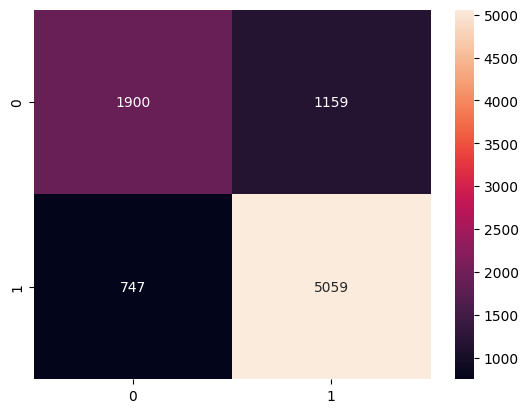

In [28]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

The dataset is not really balanced. There are 20k ones and only 10k zeros in our target variable and I think the model may only predict the majority class well but not distinguish between positive and negative classes. Looks like it is slightly better than coin toss in case of predicting negatives (which is kind of main point of this model since it was made to predict when customer going to cancel booking),

In [29]:
df['booking_status'].value_counts()

1    19294
0    10256
Name: booking_status, dtype: int64

In [30]:
# add metrics for standart scaler + regression
report = classification_report(y_test, standart_scaler_predictions, output_dict=True)
roc_auc = round(roc_auc_score(y, standart_scaler_model.predict_proba(X.values)[:, 1]), 2)
get_metrics(report=report,metrics_df=metrics_df, 
            column_name='StandardScaler + LogisticRegression',roc_auc_variable=roc_auc)

In [31]:
# add metrics for standart scaler + regularization + regression
report = classification_report(y_test, standart_scaler_regularization_predictions, output_dict=True)
roc_auc = round(roc_auc_score(y, standart_scaler_regularization_model.predict_proba(X.values)[:, 1]), 2)
get_metrics(report=report,metrics_df=metrics_df, 
            column_name='StandardScaler + Regularization + LogisticRegression',roc_auc_variable=roc_auc)

In [32]:
metrics_df

,Metric,Basic Model,StandardScaler + LogisticRegression,StandardScaler + Regularization + LogisticRegression
0,Total accuracy,0.78,0.78,0.81
1,Macro precision,0.77,0.77,0.80
2,Macro recall,0.75,0.75,0.78
3,Macro F1,0.75,0.75,0.78
4,Weighted precision,0.78,0.78,0.81
5,Weighted recall,0.78,0.78,0.81
6,Weighted F1,0.78,0.78,0.81
7,ROC AUC,0.76,0.76,0.61


In [37]:
# save metrics dataset to use in next exercise
metrics_df.to_csv("metrics.csv")

In 3rd case (using pipeline of standart scaler, regularization and logistic regression) accuracy metrics goes up for 3-4 percentage points, but ROC AUC metric falls down for 15 points. As I understand, for imbalanced data, AUC performs very well and is more important while Accuracy does not perform well for imbalanced data.

<AxesSubplot: >

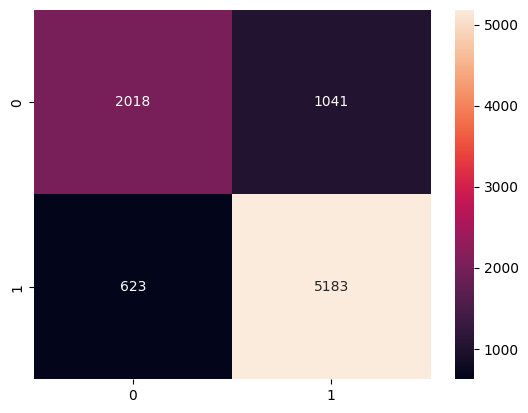

In [33]:
sns.heatmap(confusion_matrix(y_test, standart_scaler_regularization_predictions), annot=True, fmt='g')